In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [21]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.5 MB/s eta 0:00:00


In [107]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

import tensorflow.keras as k
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.models import Sequential

from numpy.random import seed

import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed


import tensorflow as tf

import os
from tensorflow.keras.losses import binary_crossentropy

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
df = pd.read_pickle('/content/drive/Shareddrives/DS4A_Fakenews/data/clean_data/clean_news.pickle')#.reset_index()
df = df.dropna()

In [6]:
df = df[df["type"] != "bias"]
df = df.reset_index().drop("index", axis=1)

In [7]:
# redo the one-hot encoding as throwing away the bias
encoder = LabelBinarizer().fit(list(df["type"]))
df["one_hot_label"] = df.apply(lambda r: encoder.transform([r['type']])[0], axis=1)
df.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title,one_hot_label
0,community still financing protecting terrorist...,\n21st Century Wire says… \nAs western media o...,fake,st century wire western media outlets like new...,"[23764, 3343, 6333, 2749, 538, 7527, 87, 65, 3...","[339, 151, 2647, 4253, 3511, 852, 0, 0, 0, 0, ...",[0]
1,director leaked memo explains reopening email ...,\n21st Century Wire says… \n21WIRE reported on...,fake,st century wire wire reported surprising annou...,"[23764, 3343, 6333, 6333, 343, 4543, 1744, 47,...","[445, 8507, 7490, 4107, 15821, 2227, 288, 0, 0...",[0]
2,behind new probe emails,\nIn a stunning turn of events 11 days before ...,fake,stunning turn events days presidential electio...,"[5682, 749, 696, 255, 1929, 631, 340, 915, 222...","[474, 65, 4030, 9451, 0, 0, 0, 0, 0, 0, 0, 0]",[0]
3,party corruption campaign directly tied disgra...,A tidal wave of revelations is pouring out of ...,fake,tidal wave revelations pouring campaign presid...,"[33871, 3512, 12193, 11059, 537, 1929, 631, 61...","[447, 2873, 537, 1595, 1544, 21356, 4158, 0, 0...",[0]
4,hack hoax biggest lie election season,"November 1, 2016 By 21wire 4 Comments \nPatric...",fake,wire comments st century wire longer soap oper...,"[6333, 691, 23764, 3343, 6333, 951, 13293, 100...","[19787, 17820, 724, 4678, 631, 114, 0, 0, 0, 0...",[0]


In [8]:
print("LABELS")
enc = encoder.transform(encoder.classes_)
for x, y in zip(encoder.classes_, enc):
    print(x, y)

LABELS
fake [0]
true [1]


In [9]:
df["one_hot_label"].value_counts()

[0]    24459
[1]    21417
Name: one_hot_label, dtype: int64

In [10]:
df["type"].value_counts()

fake    24459
true    21417
Name: type, dtype: int64

In [95]:
len_content = len(df["vectorized_clean_text"][0])
len_title = len(df['vectorized_title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 523
Max len title: 12


In [12]:
# Load the pre-trained word vectors
word_model = KeyedVectors.load_word2vec_format("/content/drive/Shareddrives/DS4A_Fakenews/data/GoogleNews-vectors-negative300.bin",
                                          binary=True, limit=50000)

In [13]:
# initializes an empty numpy array to store the word embeddings
embed_mat = np.zeros((50000, 300))
for i, key in enumerate(word_model.key_to_index):
    embed_mat[i] = word_model.get_vector(key)

In [14]:
docs = df[["vectorized_clean_text", "vectorized_title"]]
labels = df["one_hot_label"]


# test :20%
# train: 72%
# validation: 8%

# Splitting into train and test sets
X_train, X_test , y_train, y_test = train_test_split(docs, labels , test_size = 0.20, random_state = 42)

# Splitting the train data further into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [15]:
X_train_title = X_train['vectorized_title']
X_train_content = X_train['vectorized_clean_text']

X_valid_title = X_valid['vectorized_title']
X_valid_content = X_valid['vectorized_clean_text']

X_test_title = X_test['vectorized_title']
X_test_content = X_test['vectorized_clean_text']

In [16]:
train_fit = [np.asarray(X_train_title.tolist()),
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()),
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()),
             np.asarray(X_test_content.tolist())]

In [17]:
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [18]:
X_train

,vectorized_clean_text,vectorized_title
4703,"[537, 25752, 7830, 266, 31787, 45, 283, 162, 1...","[25752, 3853, 197, 1004, 537, 3102, 7500, 95, ..."
22646,"[1070, 2275, 251, 2837, 746, 0, 0, 0, 0, 0, 0,...","[2837, 1070, 4531, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1352,"[6370, 5707, 152, 40718, 113, 7504, 603, 652, ...","[25752, 1926, 852, 7504, 21443, 25561, 14756, ..."
42596,"[457, 1080, 7650, 266, 10614, 3366, 111, 1313,...","[1080, 7650, 115, 21625, 1313, 1591, 152, 353,..."
23913,"[348, 25752, 213, 15134, 4161, 3608, 536, 229,...","[4715, 555, 1059, 25752, 4161, 8124, 536, 0, 0..."
...,...,...
23266,"[23764, 3343, 6333, 115, 865, 3133, 538, 11350...","[243, 582, 25752, 5811, 11120, 2819, 1219, 311..."
21721,"[196, 509, 10594, 180, 33149, 5554, 0, 0, 0, 0...","[33149, 25752, 1908, 20057, 14619, 20173, 739,..."
28031,"[25928, 1058, 164, 16943, 754, 2151, 956, 9, 1...","[164, 4264, 115, 1723, 75, 142, 3761, 671, 715..."
44104,"[13473, 447, 383, 238, 2506, 969, 447, 9, 3429...","[13473, 447, 3111, 2655, 473, 969, 0, 0, 0, 0,..."


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from numpy.random import seed

from tensorflow.random import set_seed as tf_set_seed
from skopt.space import Integer, Real
from skopt import gp_minimize


In [51]:
len_content

523

In [52]:
len_title

12

In [108]:
@use_named_args(space)
def cnn_model(**params):

    x_train = train_fit
    y_train2 = np.array(y_train.tolist())

    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())

    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    # Build the model architecture
    title_input = Input(shape=(len_title,), name='title_input')
    inp = Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = Conv1D(filters=params['filters1Title'], kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = MaxPooling1D(pool_size=2, name='Pool1Title')(x)
    x = Flatten()(x)
    x = Dense(params['denseTitle'], activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    # Similar layers for content_input
    content_input = Input(shape=(len_content,), name='content_input')
    inp2 = Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = Conv1D(filters=params['filtersContent'], kernel_size=16, strides=2, activation='relu', name='Conv1Content')(inp2)
    x2 = MaxPooling1D(pool_size=6, name='Pool1Content')(x2)

    x2 = Conv1D(filters=80, kernel_size=8, strides=4, activation='relu', name='Conv2Content')(inp2)
    x2 = MaxPooling1D(pool_size=2, name='Pool2Content')(x2)

    x2 = Flatten()(x2)
    x2 = Dense(params['denseContent'], activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)

    # Merge
    x = k.layers.concatenate([x, x2])

    # Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(params['dropout1'])(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(params['dropout2'])(x)

    # Output layer with single unit for binary classification
    out = k.layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(learning_rate =params['learning_rate'], momentum=params['momentum']),
                  loss=binary_crossentropy, metrics=['acc'])

    model.fit(x=[x_train[0], x_train[1]], y=y_train2, batch_size=128, epochs=20,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta=0.1)],
              validation_data=([x_valid[0], x_valid[1]], y_valid2))

    # Evaluation
    acc = model.evaluate(x=[x_test[0], x_test[1]], y=y_test2)
    return -acc[1]  # Maximize accuracy

In [101]:
# Define your hyperparameter search space
space = [
    Integer(32, 256, name='filters1Title'),
    Integer(32, 256, name='filtersContent'),
    Integer(64, 256, name='denseTitle'),
    Integer(64, 256, name='denseContent'),
    Real(0.1, 0.5, name='dropout1'),
    Real(0.1, 0.5, name='dropout2'),
    Real(1e-4, 1e-2, "log-uniform", name='learning_rate'),
    Real(0.0, 0.9, name='momentum')
]

# Bayesian Optimization
result = gp_minimize(cnn_model, dimensions=space, n_random_starts=3, n_calls=5)


Epoch 1/20
259/259 [==============================] - 6s 14ms/step - loss: 3.1305 - acc: 0.7204 - val_loss: 2.0427 - val_acc: 0.9134
Epoch 2/20
259/259 [==============================] - 3s 13ms/step - loss: 1.4923 - acc: 0.9442 - val_loss: 1.0493 - val_acc: 0.9540
Epoch 3/20
287/287 [==============================] - 1s 4ms/step - loss: 0.5570 - acc: 0.9706
Epoch 1/20
259/259 [==============================] - 6s 15ms/step - loss: 6.7589 - acc: 0.4983 - val_loss: 6.7339 - val_acc: 0.4978
Epoch 2/20
259/259 [==============================] - 3s 13ms/step - loss: 6.7098 - acc: 0.5210 - val_loss: 6.6855 - val_acc: 0.5398
Epoch 3/20
287/287 [==============================] - 1s 4ms/step - loss: 6.6375 - acc: 0.5809
Epoch 1/20
259/259 [==============================] - 5s 14ms/step - loss: 7.5553 - acc: 0.5593 - val_loss: 7.0414 - val_acc: 0.6569
Epoch 2/20
259/259 [==============================] - 4s 14ms/step - loss: 6.5135 - acc: 0.7566 - val_loss: 5.9030 - val_acc: 0.8894
Epoch 3/20
2

In [103]:

print("PARAMETERS: {}  RESULT {}".format(result.x, result.fun))

PARAMETERS: [103, 183, 117, 104, 0.45425308114898033, 0.3925741186212217, 0.007112020384325484, 0.8922306516546425]  RESULT -0.9705753922462463


array([[<Axes: xlabel="Integer(low=32, high=256, prior='uniform', transform='normalize')", ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel="Integer(low=32, high=256, prior='uniform', transform='normalize')">,
        <Axes: xlabel="Integer(low=32, high=256, prior='uniform', transform='normalize')", ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel="Integer(low=64, high=256, prior='uniform', transform='normalize')">,
        <Axes: >,
        <Axes: xlabel="Integer(low=64, high=256, prior='uniform', transform='normalize')", ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel="Integer(low=64, high=256, prior='uniform', transform='normalize')">,
        <Axes: >, <Axes: >,
        <Axes: xlabel="Integer(low=64, high=256, prior='uniform', transform='normalize')", ylabel='P

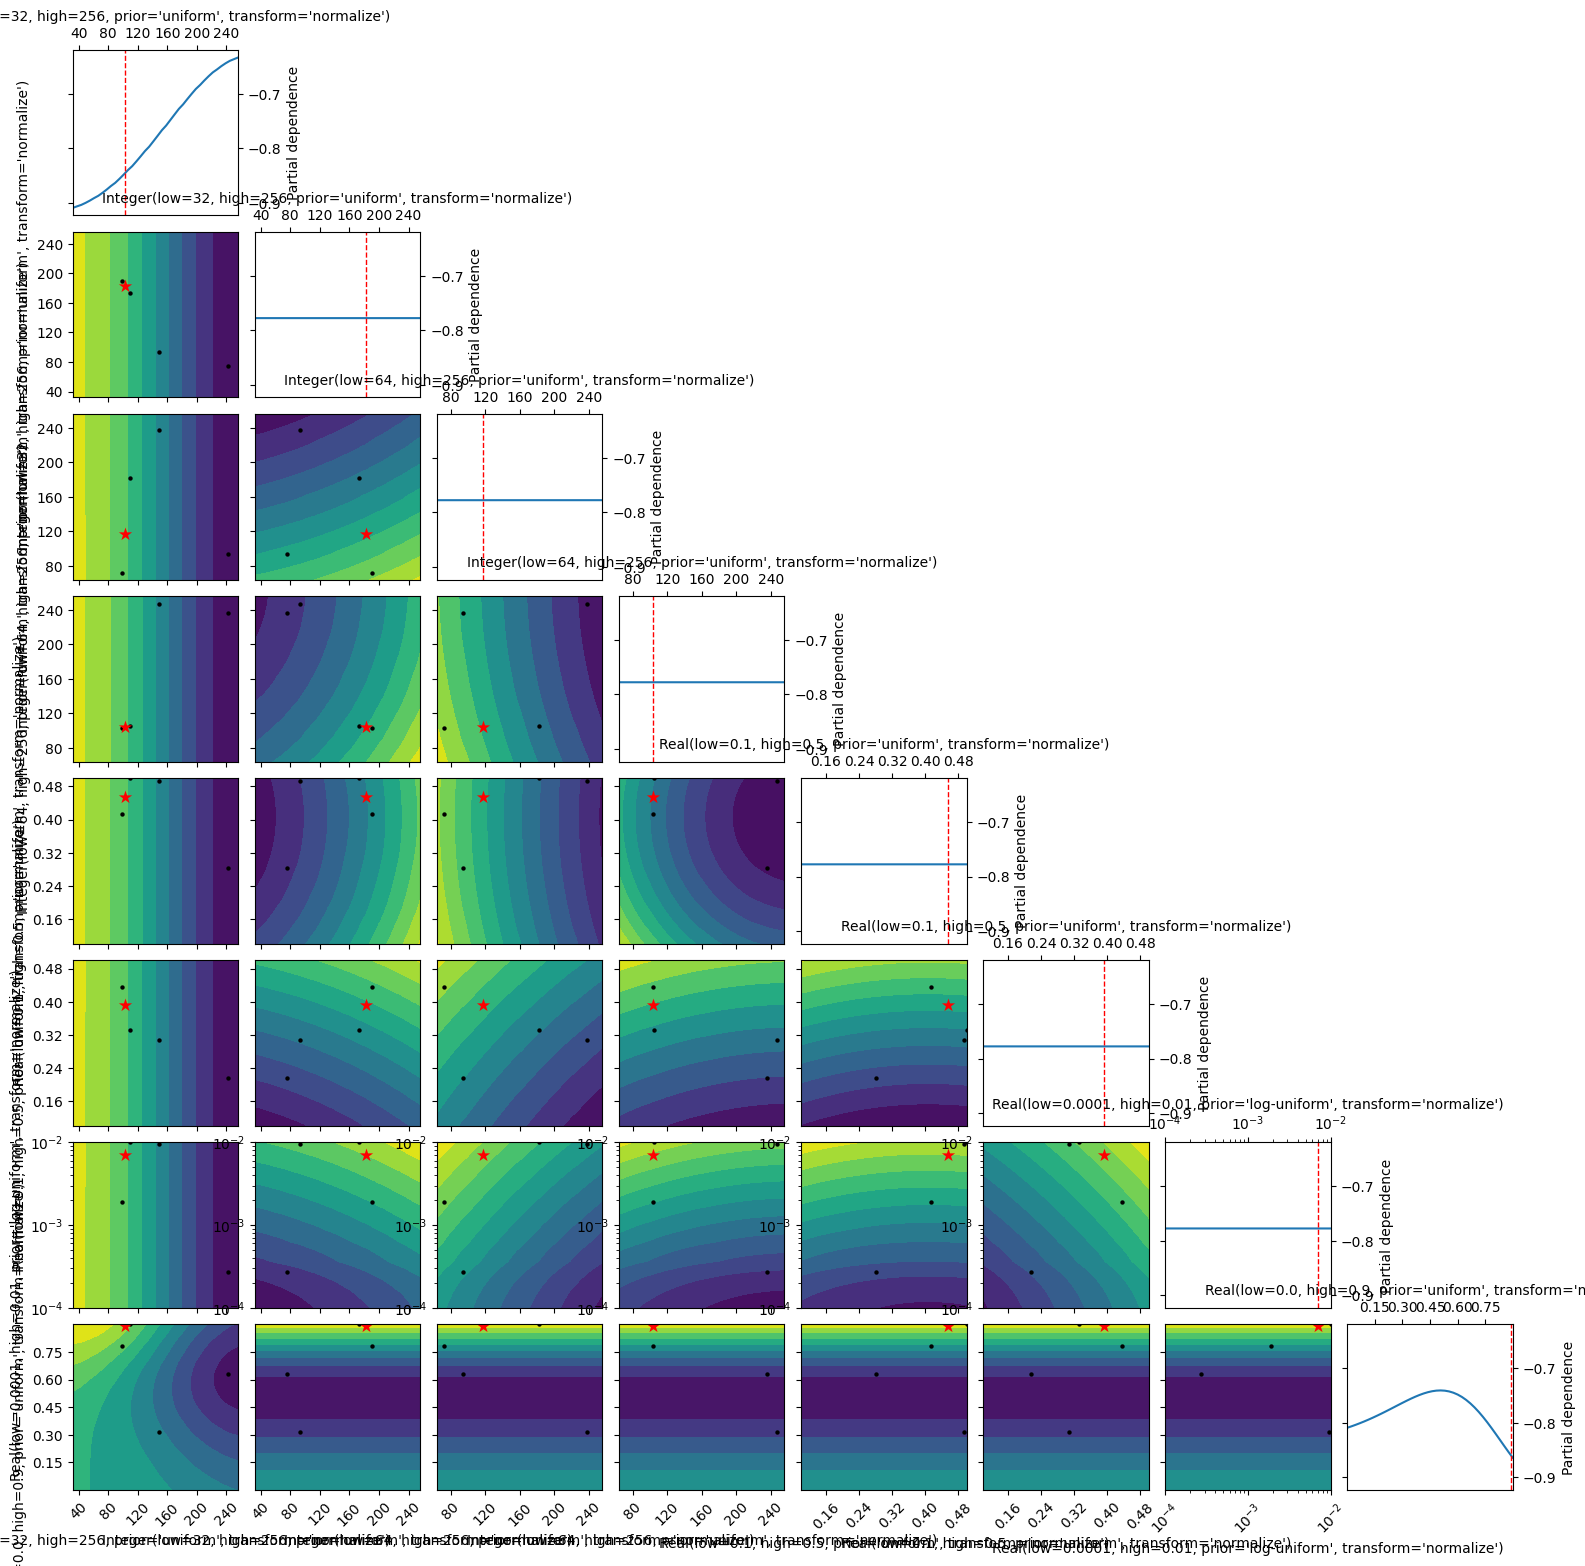

In [104]:
plot_objective(result, dimensions=space)

In [105]:
print("Params")
result.x_iters


Params


[[103,
  183,
  117,
  104,
  0.45425308114898033,
  0.3925741186212217,
  0.007112020384325484,
  0.8922306516546425],
 [242,
  75,
  94,
  236,
  0.2821627382184705,
  0.21612381910177605,
  0.0002746007159538787,
  0.6291923378813014],
 [149,
  93,
  238,
  247,
  0.4932862525541163,
  0.3071553147647207,
  0.009442387327318237,
  0.3126953164577828],
 [98,
  190,
  72,
  103,
  0.4141868078394879,
  0.4351983044225952,
  0.0019027682758426133,
  0.7797621914991152],
 [110, 173, 182, 105, 0.5, 0.3309924566746941, 0.01, 0.9]]

In [106]:
print("Values")
result.func_vals

Values


array([-0.97057539, -0.58086312, -0.76155186, -0.92033565, -0.95858765])